In [ ]:
!pip install gdown

In [ ]:
!pip install surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 11.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3163499 sha256=da8f1d071892efdaa3fceb0684d442aece69ce8c49db09a09cfab80ab58fcb45
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


In [ ]:
import gdown
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import random
import time
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")
from collections import defaultdict
from surprise import (
    Dataset,
    KNNBaseline,
    KNNBasic,
    KNNWithMeans,
    KNNWithZScore,
    NMF,
    SVD,
    SVDpp,
    Reader,
    accuracy,
    Prediction,
)
from surprise.model_selection import cross_validate, KFold, GridSearchCV, train_test_split
from tabulate import tabulate

In [ ]:
credits_id = '1OgAdH8h-8gBTh3IvZAKkfilgJ7NP_PYJ'
gdown.download(f'https://drive.google.com/uc?id={credits_id}', 'credits.csv')
credits = pd.read_csv('credits.csv')

keywords_id = '1pwuGPB-f8sX0HBZm4lXIjwVNxpgBM6EE'
gdown.download(f'https://drive.google.com/uc?id={keywords_id}', 'keywords.csv')
keywords = pd.read_csv('keywords.csv')

links_small_id = '1CeVsfXl2MHqunJXJsPhGKg9EqT5rWNhq'
gdown.download(f'https://drive.google.com/uc?id={links_small_id}', 'links_small.csv')
links_small = pd.read_csv('links_small.csv')

movies_metadata_id = '1fiKyla5QlCGq1ERb5IT7GlDVxehkLK0P'
gdown.download(f'https://drive.google.com/uc?id={movies_metadata_id}', 'movies_metadata.csv')
metadata = pd.read_csv('movies_metadata.csv')

ratings_small_id = '1rVEKuncfTQUeS8eTzT_TxThskkCqeppV'
gdown.download(f'https://drive.google.com/uc?id={ratings_small_id}', 'ratings_small.csv')
ratings_small = pd.read_csv('ratings_small.csv')

Downloading...
From: https://drive.google.com/uc?id=1OgAdH8h-8gBTh3IvZAKkfilgJ7NP_PYJ
To: /content/credits.csv
100%|██████████| 190M/190M [00:04<00:00, 45.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1pwuGPB-f8sX0HBZm4lXIjwVNxpgBM6EE
To: /content/keywords.csv
100%|██████████| 6.23M/6.23M [00:00<00:00, 238MB/s]
Downloading...
From: https://drive.google.com/uc?id=1CeVsfXl2MHqunJXJsPhGKg9EqT5rWNhq
To: /content/links_small.csv
100%|██████████| 183k/183k [00:00<00:00, 59.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1fiKyla5QlCGq1ERb5IT7GlDVxehkLK0P
To: /content/movies_metadata.csv
100%|██████████| 34.4M/34.4M [00:00<00:00, 117MB/s]
Downloading...
From: https://drive.google.com/uc?id=1rVEKuncfTQUeS8eTzT_TxThskkCqeppV
To: /content/ratings_small.csv
100%|██████████| 2.44M/2.44M [00:00<00:00, 174MB/s]


In [ ]:
### DataFrame operations

def k_from_details(details):
    try:
        return details['actual_k']
    except KeyError:
        return 1000

### Model-related functions

def get_model_name(model):
    return str(model).split('.')[-1].split(' ')[0].replace("'>", "")

def cv_multiple_models(data, models_dict, cv=3):
    results = pd.DataFrame()

    for model_name, model in models_dict.items():
        print('\n---> CV for %s...' % model_name)

        cv_results = cross_validate(model, data, cv=cv)
        tmp = pd.DataFrame(cv_results).mean()
        tmp = pd.DataFrame([tmp])
        tmp['model'] = model_name
        results = pd.concat([results, tmp], ignore_index=True)

    return results

def generate_models_dict(models, sim_names, user_based):
    models_dict = {}

    for sim_name in sim_names:
        sim_dict = {
            'name': sim_name,
            'user_based': user_based
        }
        for model in models:
            model_name = get_model_name(model) + ' ' + sim_name
            models_dict[model_name] = model(sim_options=sim_dict)

    return models_dict

def draw_model_results(results):
    fig, ax1 = plt.subplots(figsize=(10, 6))
    plt.xticks(rotation=90)

    palette = sns.color_palette("RdBu", len(results))

    sns.barplot(x='model', y='test_rmse', data=results, palette=palette, ax=ax1)
    ax1.set_title('Test RMSE and fit time of evaluated models')

    ax2 = ax1.twinx()
    sns.scatterplot(x='model', y='fit_time', data=results, color='black', ax=ax2)
    ax2.set(ylim=(0, results['fit_time'].max() * 1.1))

    plt.show()

In [ ]:
# The algorithms to cross-validate
memory_algos = (
    KNNBasic(verbose=False),
    KNNWithMeans(verbose=False),
    KNNBaseline(verbose=False),
    KNNWithZScore(verbose=False),
)

model_algos = (
    SVD(random_state=0),
    SVDpp(random_state=0, cache_ratings=False),
    NMF(random_state=0),
)


# Set RNG
np.random.seed(0)
random.seed(0)

In [ ]:
reader = Reader(rating_scale=(0.5, 5))
data = Dataset.load_from_df(ratings_small[['userId', 'movieId', 'rating']], reader)

# Memory-Based Collaborative Filtering
Memory based algorithms apply statistical techniques to the entire dataset to calculate the predictions. They can be divided into two main sections: user-item filtering and item-item filtering. The closest users or items are calculated only by using Cosine similarity or Pearson correlation coefficients, which are solely based on arithmetic operations.

Below is a summary of the 4 KNN algorithms Surprise supports.

In [ ]:
# Rest of the code remains the same
kf = KFold(random_state=0)  # folds will be the same for all algorithms.

table = []
for algo in memory_algos:
    start = time.time()
    out = cross_validate(algo, data, ["rmse", "mae"], kf)
    cv_time = str(datetime.timedelta(seconds=int(time.time() - start)))
    algo_name = algo.__class__.__name__
    mean_rmse = "{:.3f}".format(np.mean(out["test_rmse"]))
    mean_mae = "{:.3f}".format(np.mean(out["test_mae"]))

    new_line = [algo_name, mean_rmse, mean_mae, cv_time]
    table.append(new_line)

header = ["Memory-Based Algorithm", "RMSE", "MAE", "Time"]
print(tabulate(table, header, tablefmt="pipe"))

| Memory-Based Algorithm   |   RMSE |   MAE | Time    |
|:-------------------------|-------:|------:|:--------|
| KNNBasic                 |  0.969 | 0.745 | 0:00:10 |
| KNNWithMeans             |  0.92  | 0.704 | 0:00:12 |
| KNNBaseline              |  0.897 | 0.686 | 0:00:15 |
| KNNWithZScore            |  0.919 | 0.699 | 0:00:13 |


## KNN Model Selection
K-Nearest Neighbours algorithm calculates the distances between users or items and finds the closest ones = the most similar ones. The comparison of those models shows that KNNBaseline algorithm gives the best performance in terms of RMSE error and is not that time-consuming (compared to other models) when it comes to fitting it.

In [ ]:
models1 = generate_models_dict([KNNBasic, KNNWithMeans, KNNWithZScore, KNNBaseline], ['msd'], True)
results1 = cv_multiple_models(data, models1)
models1 = None
print(results1)


---> CV for KNNBasic msd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.

---> CV for KNNWithMeans msd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.

---> CV for KNNWithZScore msd...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.

---> CV for KNNBaseline msd...
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimat

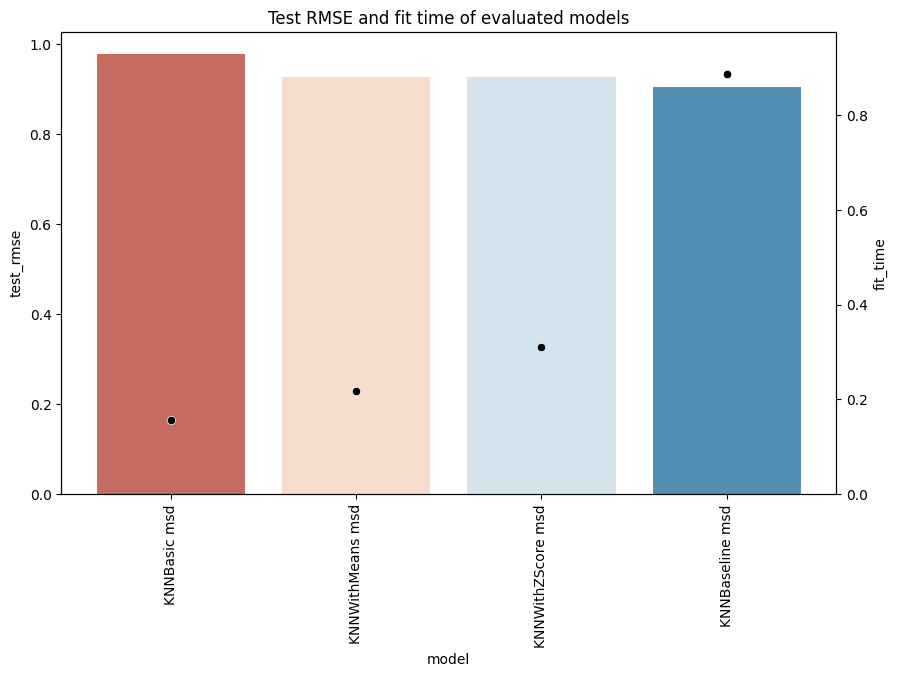

In [ ]:
draw_model_results(results1)

## User-Item Approach
User-Item approach is to determine a set of the most similar users to the user U (based on their past ratings) and to calculate the rating for the item I based on the ratings assigned by those users.

It's clear that Pearson correlation coefficient is the best both in terms of RMSE and MAE (although it's the least time efficient when fitting it)

In [ ]:
models2 = generate_models_dict([KNNBaseline], ['cosine', 'msd', 'pearson'], True) # compute similarities between users
results2 = cv_multiple_models(data, models2)
models2 = None
display(results2)


---> CV for KNNBaseline cosine...
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.

---> CV for KNNBaseline msd...
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.

---> CV for KNNBaseline pearson...
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pea

,test_rmse,test_mae,fit_time,test_time,model
0,0.909225,0.697342,0.701943,3.336517,KNNBaseline cosine
1,0.904893,0.693223,0.636062,3.735610,KNNBaseline msd
2,0.916276,0.700585,0.792783,3.266900,KNNBaseline pearson


## Item-Item Approach
Item-Item approach is to determine a set of the most similar items to the item I (based on the past ratings of other users) and to calculate the rating for the item I based on the ratings of similar items rated by the user U.

Pearson correlation coefficient gives the best results in terms of both RMSE and MAE. By using item-item approach the results of the algorithm were improved compared to the previous iteration.

In [ ]:
models3 = generate_models_dict([KNNBaseline], ['cosine', 'msd', 'pearson'], False) # compute  similarities between items
results3 = cv_multiple_models(data, models3)
models3 = None
display(results3)


---> CV for KNNBaseline cosine...
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the cosine similarity matrix...
Done computing similarity matrix.

---> CV for KNNBaseline msd...
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.

---> CV for KNNBaseline pearson...
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pea

,test_rmse,test_mae,fit_time,test_time,model
0,0.909938,0.703115,6.793320,13.897558,KNNBaseline cosine
1,0.891502,0.684912,4.237099,14.955872,KNNBaseline msd
2,0.904578,0.695131,8.687665,14.380809,KNNBaseline pearson


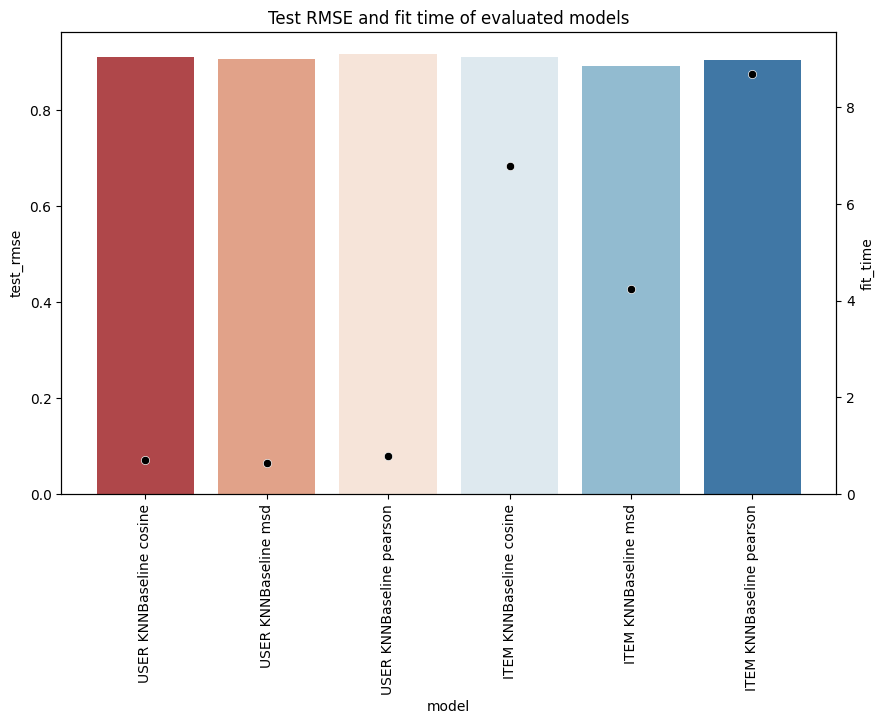

In [ ]:
results2['model'] = 'USER ' + results2['model']
results3['model'] = 'ITEM ' + results3['model']

draw_model_results(pd.concat([results2, results3]))

## Memory Based Model Optimisation with GridSearch CV
Grid Search Cross Validation computes accuracy metrics for an algorithm on various combinations of parameters, over a cross-validation procedure. It's useful for finding the best configuration of parameters.

Iterating over different sets of parameters of KNNBaseline model shows that increasing k (the max number of neighbours to take into consideration in aggregation) and min_k (the minimum number of neighbors to take into account for aggregation) improves the RMSE score. At the same time, it's good to be aware that increasing those parameters extends the training time and may also lead to overfitting. The best set of parameters (in terms of RMSE) for KNNBaseline obtained by GridSearch is:

* Item-Item
* Pearson similarity metric
* k = 50,
* min_k = 5,
* min_support = 5

In [ ]:
param_grid = {'k': [40,45,50],
              'min_k': [1,3,5],
              'sim_options': {'name': ['pearson'],
                              'min_support': [1, 5],
                              'user_based': [False]}
              }
gs = GridSearchCV(KNNBaseline, param_grid, measures=['rmse', 'mae'], cv=3)

gs.fit(data)
print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als.

## Analysis of Memory-Based Collaborative Filtering Results
In this part, let's examine in detail the results obtained by the KNN model that provided the best RMSE score.

In [ ]:
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

sim_options = {
    'name': 'pearson',
    'user_based': False,
    'min_support': 5
}

memory_model = KNNBaseline(k=50, min_k=5, sim_options=sim_options)
memory_model.fit(trainset)
memory_predictions = memory_model.test(testset)

Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.


In [ ]:
df_pred = pd.DataFrame(memory_predictions, columns=['userId', 'movieId', 'actual_rating', 'pred_rating', 'details'])

df_pred['k'] = df_pred['details'].apply(k_from_details)
df_pred['impossible'] = df_pred['details'].apply(lambda x: x['was_impossible'])
df_pred['pred_rating_round'] = df_pred['pred_rating']*2
df_pred['pred_rating_round'] = df_pred['pred_rating_round'].round()
df_pred['pred_rating_round'] = df_pred['pred_rating_round']/2
df_pred['abs_err'] = abs(df_pred['pred_rating'] - df_pred['actual_rating'])
df_pred.drop(['details'], axis=1, inplace=True)

df_pred.sample(5)

,userId,movieId,actual_rating,pred_rating,k,impossible,pred_rating_round,abs_err
14134,468,3210,3.0,2.886658,50,False,3.0,0.113342
19024,20,3196,0.5,2.904213,24,False,3.0,2.404213
13388,17,2571,5.0,4.234591,50,False,4.0,0.765409
4887,232,1562,5.0,2.892520,50,False,3.0,2.107480
17789,594,2628,4.0,3.668384,45,False,3.5,0.331616


#### Distribution of actual and predicted ratings in the test set
According to the distribution of actual ratings of movies in the test set, the biggest part of users give positive scores - between 3.0 and 5.0. The mode equals 4.0 but count of ratings 3.0 and 5.0, are also noticeable. The distribution of predicted ratings in the test set looks slightly similar. In this case, 3.5 is the mode and ratings 3.0 and 5.0 are less frequent.

It shows that this recommender system is not perfect and it cannot reflect the real distribution of movie ratings.

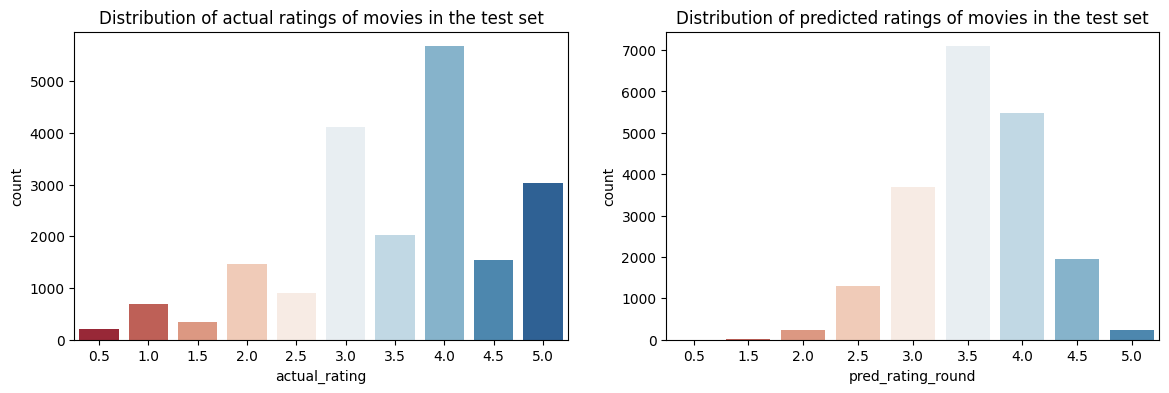

In [ ]:
palette = sns.color_palette("RdBu", 10)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))

sns.countplot(x='actual_rating', data=df_pred, palette=palette, ax=ax1)
ax1.set_title('Distribution of actual ratings of movies in the test set')

sns.countplot(x='pred_rating_round', data=df_pred, palette=palette, ax=ax2)
ax2.set_title('Distribution of predicted ratings of movies in the test set')

plt.show()

#### Absolute error of predicted ratings
The distribution of absolute errors is right-skewed, showing that the majority of errors is small: between 0 and 1. There is a long tail that indicates that there are very few observations for which the absolute error was close to 5.

As expected from the above charts, the model deals very well with predicting score = 3.5 (most frequent value). The further the rating from score = 3.5, the higher the absolute error. The biggest errors happen to observations with scores 0.5 or 1 which indicates that probably the model is predicting higher ratings for those observations.

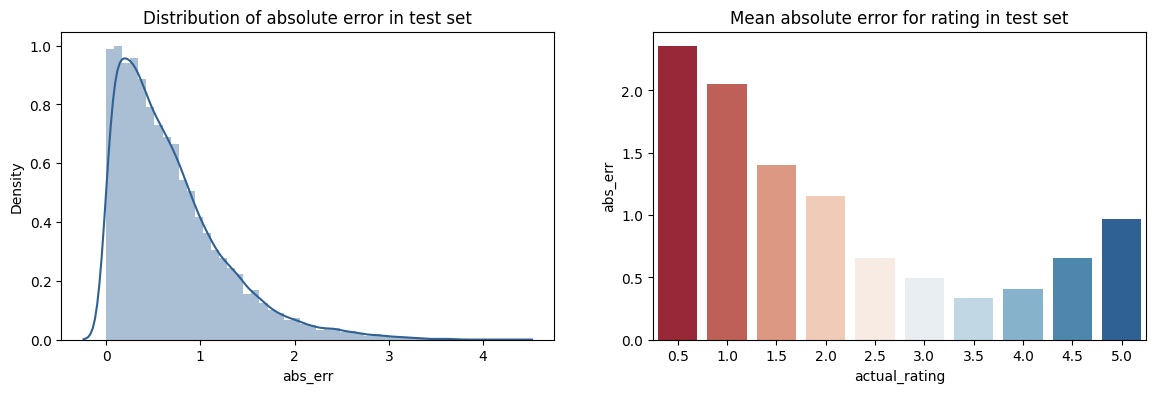

In [ ]:
df_pred_err = df_pred.groupby('actual_rating')['abs_err'].mean().reset_index()

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))

sns.distplot(df_pred['abs_err'], color='#2f6194', ax=ax1)
ax1.set_title('Distribution of absolute error in test set')

sns.barplot(x='actual_rating', y='abs_err', data=df_pred_err, palette=palette, ax=ax2)
ax2.set_title('Mean absolute error for rating in test set')

plt.show()

#### Analysis of predicted ratings of a particular user
For this part of the analysis, the user with id 345 was selected. It can be noted that his rating behaviour is slightly different than the behaviour shown in scores' distribution of the whole population. He gives more ratings at 4 and 4.5, with rating = 4.5 being the most frequent value.

The distribution of predicted movie ratings for this user has some similarities with the actual one. There are many predicted ratings near 3.5 and 4.0  (which shows that the model might mistake 4.0 and 4.5 for 3.5 and 4.0 respectively) and the most frequent rating is 4.0 (which implies that probably some of the observations with the real score = 4.5 have predicted rating lower than actual). There were also no predict 5.0 ratings.

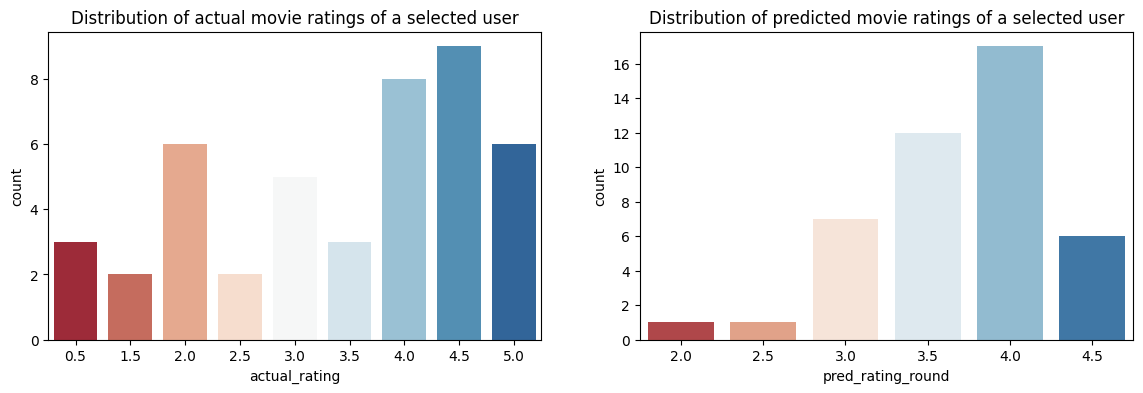

In [ ]:
df_links = pd.read_csv('links_small.csv')
df_pred = df_pred.merge(df_links[['movieId', 'tmdbId']], on='movieId', how='left')

df_movies = pd.read_csv('movies_metadata.csv')
df_movies['id'] = pd.to_numeric(df_movies['id'], errors='coerce')
df_movies = df_movies.dropna(subset=['id'])
df_movies['id'] = df_movies['id'].astype(int)
df_movies = df_movies.rename(columns = {'id':'tmdbId'})
df_movies = df_movies.drop_duplicates(subset='tmdbId', keep='first')
df_pred_ext = df_pred.merge(df_movies[['tmdbId', 'title']], on='tmdbId', how='left')

selected_user_id = 345

df_pred_user = df_pred_ext[df_pred_ext['userId']==selected_user_id]
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))

sns.countplot(x='actual_rating', data=df_pred_user, palette=sns.color_palette("RdBu", len(df_pred_user['actual_rating'].unique())), ax=ax1)
ax1.set_title('Distribution of actual movie ratings of a selected user')

sns.countplot(x='pred_rating_round', data=df_pred_user, palette=sns.color_palette("RdBu", len(df_pred_user['pred_rating_round'].unique())), ax=ax2)
ax2.set_title('Distribution of predicted movie ratings of a selected user')

plt.show()

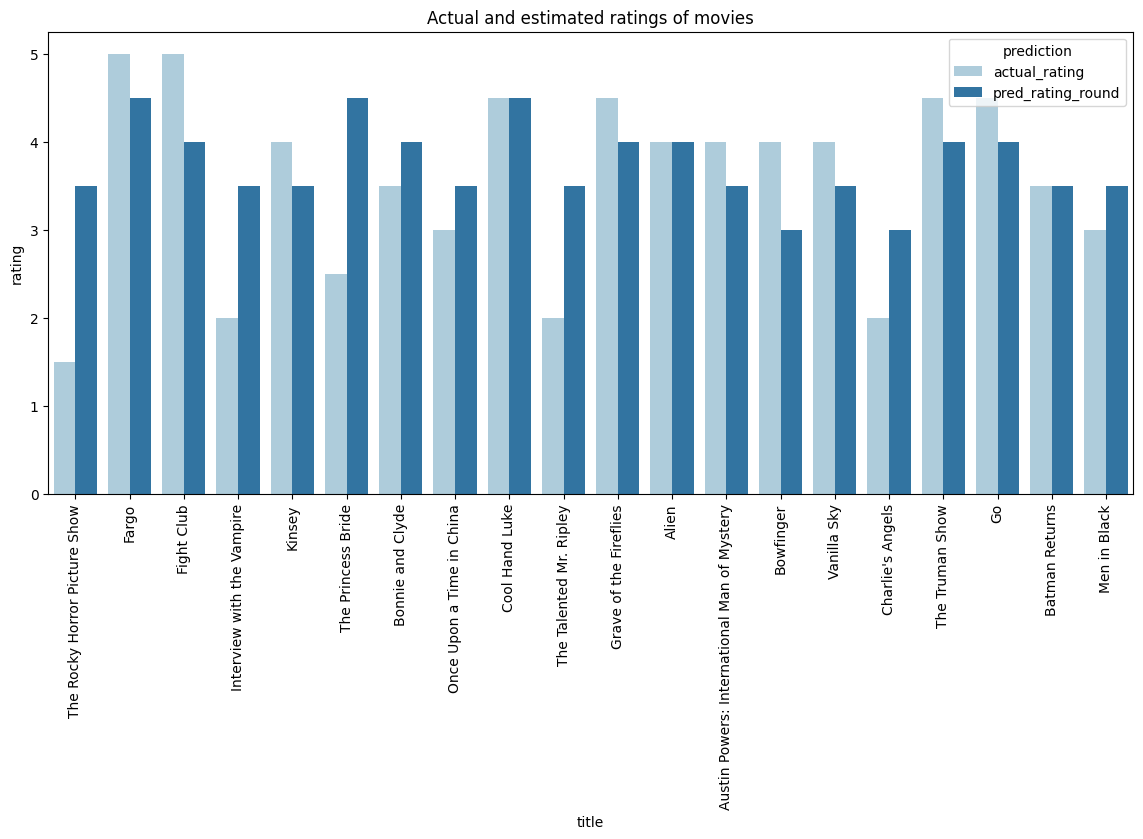

In [ ]:
df_pred_sample = df_pred_user[df_pred_user['pred_rating_round'].notna()].sample(20)
df_pred_sample = pd.melt(df_pred_sample[['title', 'actual_rating', 'pred_rating_round']], id_vars='title', var_name='prediction', value_name='rating')

fig, ax = plt.subplots(figsize=(14, 6))

sns.barplot(x='title', y='rating', hue='prediction', data=df_pred_sample, palette=sns.color_palette("Paired"))
ax.set_title('Actual and estimated ratings of movies')
plt.xticks(rotation=90)

plt.show()

# Model-Based Collaborative Filtering

Model based approach involves building machine learning algorithms to predict user's ratings. They involve dimensionality reduction methods that reduce high dimensional matrix containing abundant number of missing values with a much smaller matrix in lower-dimensional space.

Below is a summary of the model-based approaches Surprise supports. We can see that SVD++, which is an extension of SVD that takes into account implicit ratings, takes a very long computing time, although it gives the lowest RMSE and MAE. As such, we would exclude it from the model selection process.

In [ ]:
# Rest of the code remains the same
kf = KFold(random_state=0)  # folds will be the same for all algorithms.

table = []
for algo in model_algos:
    start = time.time()
    out = cross_validate(algo, data, ["rmse", "mae"], kf)
    cv_time = str(datetime.timedelta(seconds=int(time.time() - start)))
    algo_name = algo.__class__.__name__
    mean_rmse = "{:.3f}".format(np.mean(out["test_rmse"]))
    mean_mae = "{:.3f}".format(np.mean(out["test_mae"]))

    new_line = [algo_name, mean_rmse, mean_mae, cv_time]
    table.append(new_line)

header = ["Model-Based Algorithm", "RMSE", "MAE", "Time"]
print(tabulate(table, header, tablefmt="pipe"))

| Model-Based Algorithm   |   RMSE |   MAE | Time    |
|:------------------------|-------:|------:|:--------|
| SVD                     |  0.895 | 0.689 | 0:00:11 |
| SVDpp                   |  0.886 | 0.679 | 0:07:55 |
| NMF                     |  0.946 | 0.726 | 0:00:26 |


## SVD and NMF Models Selection
Singular Value Decomposition (SVD) and Non-negative Matrix Factorization (NMF) are matrix factorization techniques used for dimensionality reduction.

It's clear that for the given dataset much better results can be obtained with SVD approach - both in terms of accuracy and training time.

In [ ]:
model_svd = SVD()
cv_results_svd = cross_validate(model_svd, data, cv=3)
pd.DataFrame(cv_results_svd).mean()

test_rmse    0.903616
test_mae     0.696901
fit_time     1.601280
test_time    0.435797
dtype: float64

In [ ]:
model_nmf = NMF()
cv_results_nmf = cross_validate(model_nmf, data, cv=3)
pd.DataFrame(cv_results_nmf).mean()

test_rmse    0.961074
test_mae     0.738708
fit_time     1.808392
test_time    0.265669
dtype: float64

## Optimisation of SVD
Grid Search Cross Validation computes accuracy metrics for an algorithm on various combinations of parameters, over a cross-validation procedure. It's useful for finding the best configuration of parameters.

It is used to find the best setting of parameters:

* n_factors - the number of factors
* n_epochs - the number of iteration of the SGD procedure
* lr_all - the learning rate for all parameters
* reg_all - the regularization term for all parameters

The improvement obtained with Grid Search is very small. But the best set of parameters (in terms of RMSE) obtained by GridSearch is:

'n_factors': 80, 'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.2

In [ ]:
param_grid = {'n_factors': [80,100,120],
              'n_epochs': [5, 10, 20],
              'lr_all': [0.002, 0.005],
              'reg_all': [0.2, 0.4, 0.6]}

gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)
gs.fit(data)

print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

0.8984510801273933
{'n_factors': 80, 'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.2}


## Analysis of Model-Based Collaborative Filtering Results
In this part, let's examine in detail the results obtained by the SVD model that provided the best RMSE score.

In [ ]:
svd_model = SVD(n_factors=80, n_epochs=20, lr_all=0.005, reg_all=0.2)
svd_model.fit(trainset)
svd_predictions = svd_model.test(testset)

In [ ]:
df_pred2 = pd.DataFrame(svd_predictions, columns=['userId', 'movieId', 'actual_rating', 'pred_rating', 'details'])

df_pred2['impossible'] = df_pred2['details'].apply(lambda x: x['was_impossible'])
df_pred2['pred_rating_round'] = df_pred2['pred_rating']*2
df_pred2['pred_rating_round'] = df_pred2['pred_rating_round'].round()
df_pred2['pred_rating_round'] = df_pred2['pred_rating_round']/2
df_pred2['abs_err'] = abs(df_pred2['pred_rating'] - df_pred2['actual_rating'])
df_pred2.drop(['details'], axis=1, inplace=True)

df_pred2.sample(5)

,userId,movieId,actual_rating,pred_rating,impossible,pred_rating_round,abs_err
8062,309,1262,5.0,4.289033,False,4.5,0.710967
14561,382,6942,3.5,3.382797,False,3.5,0.117203
9425,664,1270,4.0,4.076237,False,4.0,0.076237
1220,654,1748,4.0,4.073211,False,4.0,0.073211
19728,441,1197,3.5,4.090905,False,4.0,0.590905


#### Distribution of actual and predicted ratings in the test set
According to the distribution of actual ratings of movies in the test set, the biggest part of users give positive scores - between 4.0 and 5.0. The mode is 4.0 but count of ratings 3.0 and 5.0 is also noticeable. The distribution of predicted ratings in the test set is visibly different. 3.5 is the mode but score 5.0 is clearly less frequent.

It shows that the recommender system is not perfect and it cannot reflect the real distribution of movie ratings.

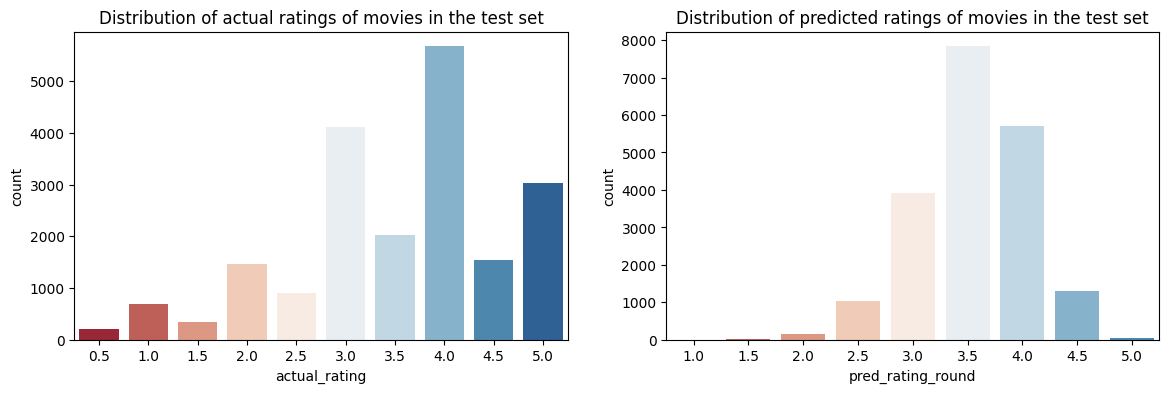

In [ ]:
palette = sns.color_palette("RdBu", 10)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))

sns.countplot(x='actual_rating', data=df_pred2, palette=palette, ax=ax1)
ax1.set_title('Distribution of actual ratings of movies in the test set')

sns.countplot(x='pred_rating_round', data=df_pred2, palette=palette, ax=ax2)
ax2.set_title('Distribution of predicted ratings of movies in the test set')

plt.show()

#### Absolute error of predicted ratings
Similar to Memory-based Collaborative Filtering, the distribution of absolute errors is right-skewed, showing that the majority of errors is small: between 0 and 1. There is a long tail that indicates that there are very few observations for which the absolute error was close to 5.

How good/bad the model is with predicting certain scores? As expected from the above charts, the model deals very well with predicting score = 3.5 (the most frequent value). The further the rating from score = 3.5, the higher the absolute error. The biggest errors happen to observations with scores 1 or 2 which indicates that probably the model is predicting higher ratings for those observations.

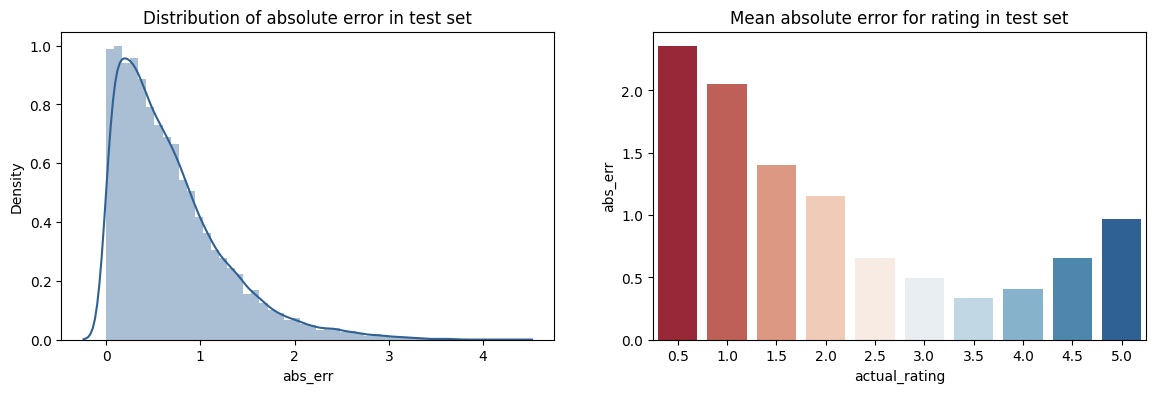

In [ ]:
df_pred2_err = df_pred2.groupby('actual_rating')['abs_err'].mean().reset_index()

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))

sns.distplot(df_pred['abs_err'], color='#2f6194', ax=ax1)
ax1.set_title('Distribution of absolute error in test set')

sns.barplot(x='actual_rating', y='abs_err', data=df_pred_err, palette=palette, ax=ax2)
ax2.set_title('Mean absolute error for rating in test set')

plt.show()

#### Analysis of predicted ratings of a particular user
For this part of the analysis, the user with id 345 was selected. In the first table below, we analyze the 10 highest predicted movie ratings for this user.

In the other table below, it shows the actual top 10 rated movies by this user. We can see that our prediction managed to predict some of the movies in the top 10, even though the value of the predicted rating might be slightly different from the actual ratings.

In [ ]:
df_links = pd.read_csv('links_small.csv')
df_pred2 = df_pred2.merge(df_links[['movieId', 'tmdbId']], on='movieId', how='left')

df_movies = pd.read_csv('movies_metadata.csv')
df_movies['id'] = pd.to_numeric(df_movies['id'], errors='coerce')
df_movies = df_movies.dropna(subset=['id'])
df_movies['id'] = df_movies['id'].astype(int)
df_movies = df_movies.rename(columns = {'id':'tmdbId'})
df_movies = df_movies.drop_duplicates(subset='tmdbId', keep='first')
df_pred2_ext = df_pred2.merge(df_movies[['tmdbId', 'title']], on='tmdbId', how='left')

selected_user_id = 345

df_pred2_user = df_pred2_ext[df_pred2_ext['userId']==selected_user_id]

df_pred2_user[df_pred2_user['pred_rating'].notna() & df_pred2_user['title'].notna()].sort_values('pred_rating', ascending=False).head(10)

,userId,movieId,actual_rating,pred_rating,impossible,pred_rating_round,abs_err,tmdbId,title
15667,345,6016,4.5,4.312889,False,4.5,0.187111,598.0,City of God
10182,345,608,5.0,4.193329,False,4.0,0.806671,275.0,Fargo
9898,345,903,4.5,4.189983,False,4.0,0.310017,426.0,Vertigo
19392,345,1276,4.5,4.180386,False,4.0,0.319614,903.0,Cool Hand Luke
18656,345,4993,4.0,4.175193,False,4.0,0.175193,120.0,The Lord of the Rings: The Fellowship of the Ring
9536,345,1197,2.5,4.142628,False,4.0,1.642628,2493.0,The Princess Bride
6733,345,2959,5.0,4.128732,False,4.0,0.871268,550.0,Fight Club
8739,345,1617,4.0,4.071769,False,4.0,0.071769,2118.0,L.A. Confidential
10640,345,30749,4.5,4.026638,False,4.0,0.473362,205.0,Hotel Rwanda
6597,345,4361,3.0,4.017695,False,4.0,1.017695,9576.0,Tootsie


In [ ]:
df_pred2_user[df_pred2_user['pred_rating'].notna() & df_pred2_user['title'].notna()].sort_values('actual_rating', ascending=False).head(10)

,userId,movieId,actual_rating,pred_rating,impossible,pred_rating_round,abs_err,tmdbId,title
10182,345,608,5.0,4.193329,False,4.0,0.806671,275.0,Fargo
5774,345,223,5.0,3.947321,False,4.0,1.052679,2292.0,Clerks
10921,345,1220,5.0,3.828864,False,4.0,1.171136,525.0,The Blues Brothers
11403,345,5060,5.0,3.805474,False,4.0,1.194526,651.0,M*A*S*H
6733,345,2959,5.0,4.128732,False,4.0,0.871268,550.0,Fight Club
10219,345,6874,5.0,3.831300,False,4.0,1.168700,24.0,Kill Bill: Vol. 1
17933,345,5690,4.5,3.927151,False,4.0,0.572849,12477.0,Grave of the Fireflies
9898,345,903,4.5,4.189983,False,4.0,0.310017,426.0,Vertigo
15667,345,6016,4.5,4.312889,False,4.5,0.187111,598.0,City of God
13808,345,2791,4.5,3.842573,False,4.0,0.657427,813.0,Airplane!


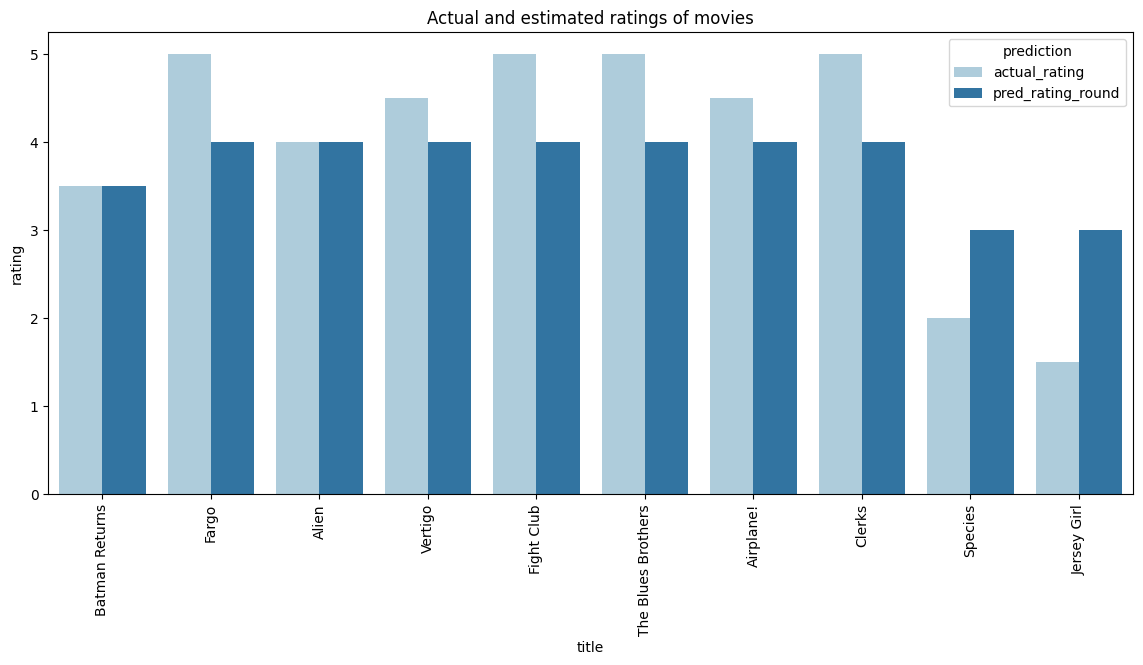

In [ ]:
df_pred2_sample = df_pred2_user[df_pred2_user['pred_rating_round'].notna()].sample(10)
df_pred2_sample = pd.melt(df_pred2_sample[['title', 'actual_rating', 'pred_rating_round']], id_vars='title', var_name='prediction', value_name='rating')

fig, ax = plt.subplots(figsize=(14, 6))

sns.barplot(x='title', y='rating', hue='prediction', data=df_pred2_sample, palette=sns.color_palette("Paired"))
ax.set_title('Actual and estimated ratings of movies')
plt.xticks(rotation=90)

plt.show()

# Hybrid Collaborative Filtering
Here, we attempt to make a hybrid collaborative filtering recommender, by using the predictions from each of the models and combining the result with static weightings.

In [ ]:
def get_actual_rating(uid, iid, predictions):
    for pred in predictions:
        if pred.uid == uid and pred.iid == iid:
            return pred.r_ui
    return None

def combine_predictions(predictions_model, predictions_memory):
    combined_predictions = {}

    for prediction in predictions_model:
        uid, iid, est = prediction.uid, prediction.iid, prediction.est
        combined_predictions[(uid, iid)] = [est]

    for prediction in predictions_memory:
        uid, iid, est = prediction.uid, prediction.iid, prediction.est
        if (uid, iid) in combined_predictions:
            combined_predictions[(uid, iid)].append(est)
        else:
            combined_predictions[(uid, iid)] = [est]

    # Create hybrid predictions
    hybrid_predictions = []
    for (uid, iid), estimates in combined_predictions.items():
        actual_rating = get_actual_rating(uid, iid, predictions_model)
        if actual_rating is not None:
            est = np.mean(estimates)
            hybrid_predictions.append(Prediction(uid, iid, actual_rating, est, {}))

    return hybrid_predictions

# Create hybrid predictions by averaging the estimates from both models
hybrid_predictions = combine_predictions(svd_predictions, memory_predictions)

## Accuracies of All Models
From the RMSE and MAE of all 3 models, we can see that the hybrid model has the lowest RMSE, followed by KNNBaseline and SVD, which are very close. While the MAE is a useful measure of overall error, in the context of recommendation systems, the ability to minimize larger errors (as indicated by a lower RMSE) is often more valuable. This is because large errors can lead to particularly poor recommendations that might significantly impact a user's experience. Therefore, even though the hybrid model may have a slightly higher MAE than one of the individual models, its ability to more effectively manage the size of errors makes it the preferred choice for our final recommender system.  As such, we will be incorporating this hybrid model into our final hybrid recommender.

In [ ]:
print('KNN RMSE: ', accuracy.rmse(memory_predictions, verbose=False))
print('KNN MAE: ', accuracy.mae(memory_predictions, verbose=False))
print('SVD RMSE: ', accuracy.rmse(svd_predictions, verbose=False))
print('SVD MAE: ', accuracy.mae(svd_predictions, verbose=False))
print('Hybrid RMSE: ', accuracy.rmse(hybrid_predictions, verbose = False))
print('Hybrid MAE: ', accuracy.mae(hybrid_predictions, verbose = False))

KNN RMSE:  0.892730068184935
KNN MAE:  0.6850018934094976
SVD RMSE:  0.9003009642503401
SVD MAE:  0.6971941830265678
Hybrid RMSE:  0.8911682450537224
Hybrid MAE:  0.6872562416807455
